In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [32]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

def show(image1, title1, image2, title2):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(image1, cmap='gray')
    plt.title(title1)

    plt.subplot(1,2,2)
    plt.imshow(image2, cmap='gray')
    plt.title(title2)

    plt.show()

import math

def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False

def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255

Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона

Алгоритм разрастания регионов с критерием однородности - average: коэффициенты (3,11)

31
66
104
129
190
184
215
228
191
154
164
158
149
147
141
139
125
115
110
85
61
36
13
4
0


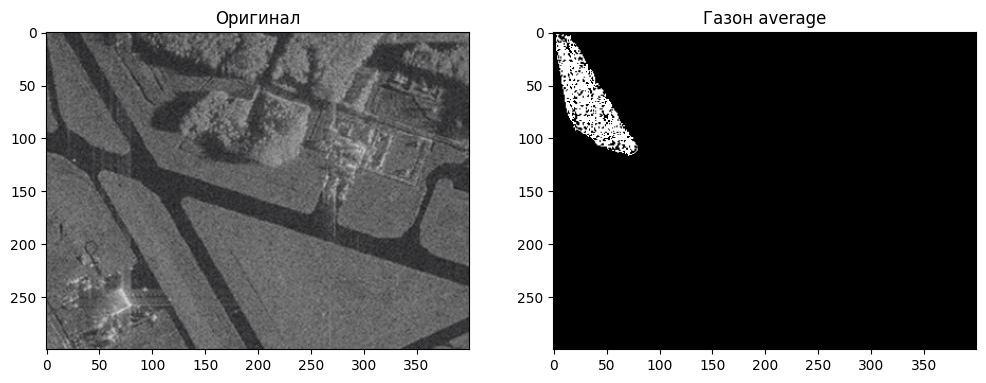

In [33]:
seed_point = (50,25)
mask = region_growing(image_gray,seed_point,homo_average,3, 11)
show(image, 'Оригинал', mask, 'Газон average')

Реализуйте вычисление критерия однородности, отличного от представленного

Алгоритм разрастания регионов с критерием однородности - median: коэффициенты (3,11)

In [34]:
def homo_median(image, mask, point, T):
    if np.count_nonzero(mask > 0) == 0:
        return False
    
    median_val = np.median(image[mask > 0])
    
    if abs(median_val - image[point]) <= T:
        return True
    
    return False

31
66
107
139
197
190
221
199
224
161
166
161
150
152
145
142
126
121
118
91
142
35
14
4
0


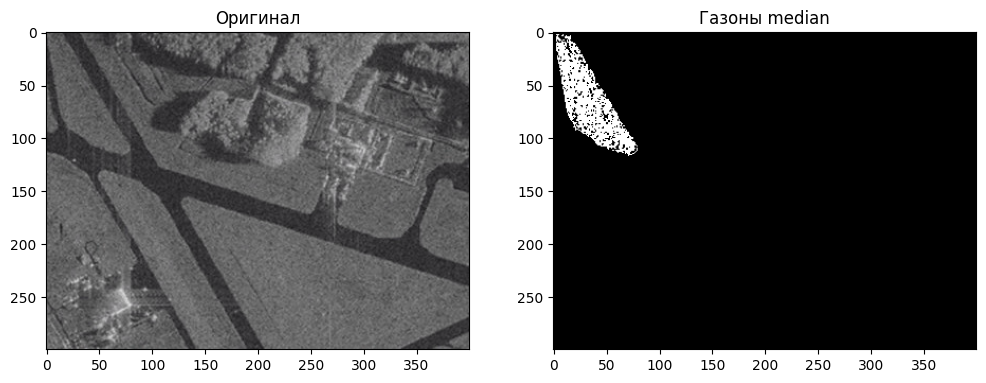

In [36]:
mask_median = region_growing(image_gray,seed_point,homo_median,3, 11)

show(image, 'Оригинал', mask_median, 'Газоны median')

Сравните результаты

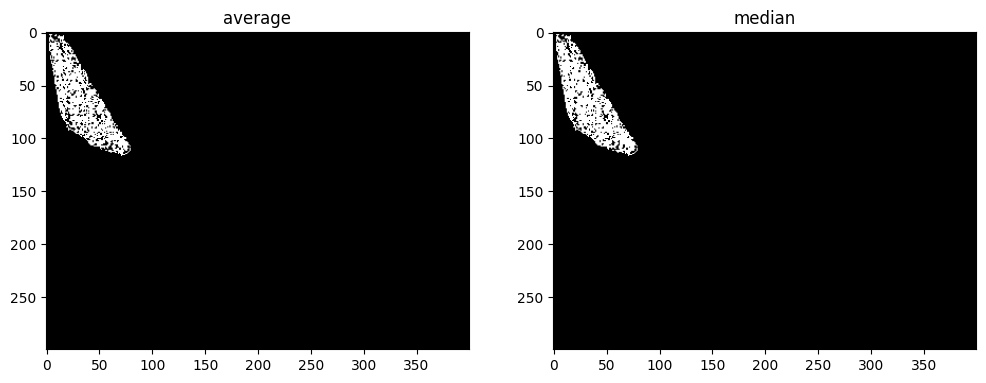

average: SSIM = 0.0027; MSE = 9417.4590
median: SSIM = 0.0034; MSE = 9431.3543


In [41]:
from skimage.metrics import structural_similarity, mean_squared_error

(ssim_average, diff_average) = structural_similarity(image_gray, mask, full=True)
(ssim_median, diff_median) = structural_similarity(image_gray, mask_median, full=True)

mse_average = mean_squared_error(image_gray, mask)
mse_median = mean_squared_error(image_gray, mask_median)

diff_average = (diff_average * 255).astype("uint8")
diff_median = (diff_median * 255).astype("uint8")

show(mask, 'average',mask_median, 'median')
print(f"average: SSIM = {ssim_average:.4f}; MSE = {mse_average:.4f}")
print(f"median: SSIM = {ssim_median:.4f}; MSE = {mse_median:.4f}")

Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [42]:
image = cv2.imread('palm_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

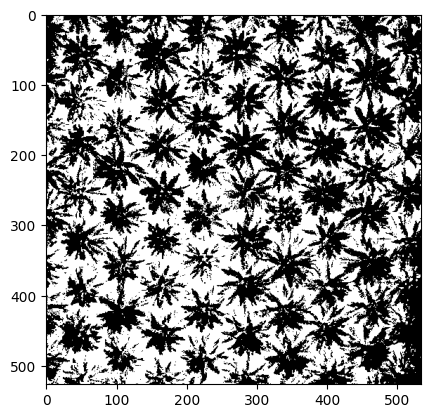

In [43]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray")

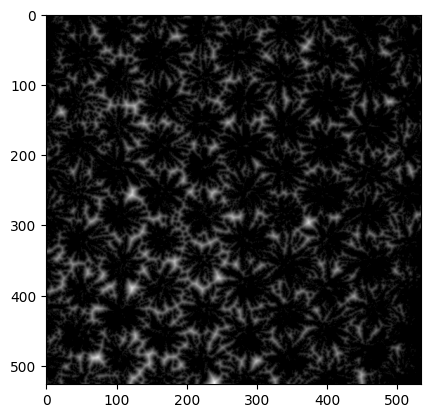

In [44]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

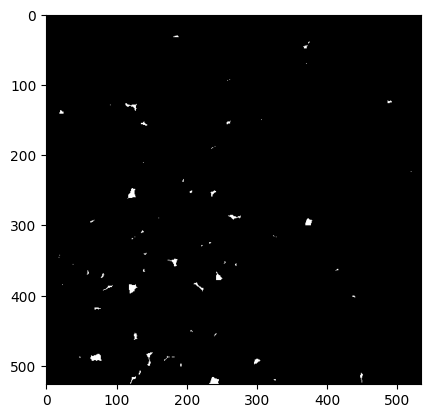

In [82]:
ret, sure_fg = cv2.threshold(dist, 0.55 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

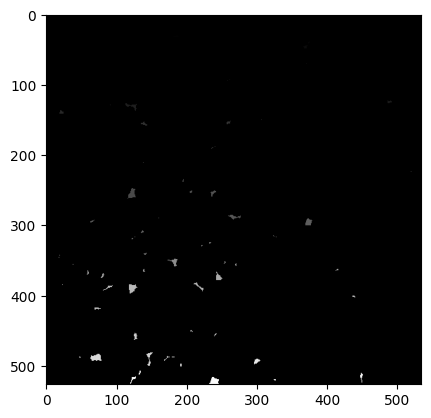

In [83]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg) 
plt.imshow(markers, cmap="gray")

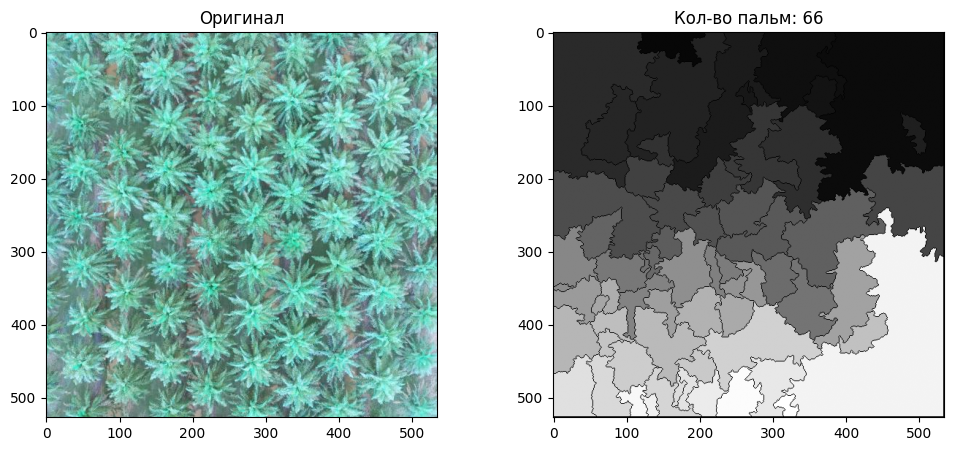

In [84]:
markers = cv2.watershed(image, markers)
show(image, 'Оригинал', markers, "Кол-во пальм: "+str(len(np.unique(markers))))